# Pandas and Matplotlib

This tutorial shows examples of using the `pandas` and `matplotlib` packages together. Data shaping tasks can be effectively done using `pandas` data frames, and visualizations can be created using `matplotlib`. Tasks in this tutorial may require either or both of these packages.

Basic knowledge of the `numpy`, `pandas`, and `matplotlib` packages is required.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Some exercises in this notebook (especially data shaping tasks) **may be mandatory** before continuing with subsequent tasks.

The Curry Shots dataset is used for this demonstration. This contains several thousand rows, each representing an attempted shot of Stephen Curry basketball player during his professional career.

If you run this notebook in Google Colab, do not forget to upload the file `curryshots.csv` for the session.

In [4]:
df = pd.read_csv('curryshots.csv')
df.head(3)

,ID,Player,Season,Top.px. (Location),Left.px. (location),Date,Opponent,Location,Quarter,Game_Clock,"Outcome (1 if made, 0 otherwise)",Shot_Value,Shot_Distance.ft.,Team_Score,Opponent_Score
0,curryst01,Stephen Curry,2010,299,339,102809,HOU,HOME,1,11:25,0,3,27,2,0
1,curryst01,Stephen Curry,2010,195,118,102809,HOU,HOME,1,9:31,1,2,19,4,2
2,curryst01,Stephen Curry,2010,179,180,102809,HOU,HOME,1,6:02,0,2,14,8,12


Note: during this tutorial, it is often advisable to create a backup of a `DataFrame` in a given state, that can be restored if the data shaping steps need to be redone.

The `copy()` function creates a copy explicitly. Note that `df_orig = df` would only create a reference to the original.

In [5]:
df_original_loaded = df.copy() # creating a backup

In [6]:
df = df_original_loaded.copy() # loading the backup
df.head(3)

,ID,Player,Season,Top.px. (Location),Left.px. (location),Date,Opponent,Location,Quarter,Game_Clock,"Outcome (1 if made, 0 otherwise)",Shot_Value,Shot_Distance.ft.,Team_Score,Opponent_Score
0,curryst01,Stephen Curry,2010,299,339,102809,HOU,HOME,1,11:25,0,3,27,2,0
1,curryst01,Stephen Curry,2010,195,118,102809,HOU,HOME,1,9:31,1,2,19,4,2
2,curryst01,Stephen Curry,2010,179,180,102809,HOU,HOME,1,6:02,0,2,14,8,12


The starting point of most exercises and tasks will be a backup of the current state. Creating an own copy of this backup should be the first step of the solution code. This makes sure that the same cell can be executed multiple times, giving the same result. The same applies to the solution code.

# Data shaping

Many `pandas` functions have an option to pass `inplace=True` to mutate the current data frame instead of returning the result of the operation.

The following example shows how to rename and drop columns.

In [7]:
df = df_original_loaded.copy()

df.rename(columns={'ID': 'row_id'}, inplace=True)
df = df.rename(columns={'Player': 'player_name'})
df.drop(['Season'], axis=1, inplace=True)
df.head(3)

,row_id,player_name,Top.px. (Location),Left.px. (location),Date,Opponent,Location,Quarter,Game_Clock,"Outcome (1 if made, 0 otherwise)",Shot_Value,Shot_Distance.ft.,Team_Score,Opponent_Score
0,curryst01,Stephen Curry,299,339,102809,HOU,HOME,1,11:25,0,3,27,2,0
1,curryst01,Stephen Curry,195,118,102809,HOU,HOME,1,9:31,1,2,19,4,2
2,curryst01,Stephen Curry,179,180,102809,HOU,HOME,1,6:02,0,2,14,8,12


Additional columns can be introduced using formulas based on other columns.

In [8]:
df['Shot_Distance.m'] = df['Shot_Distance.ft.'] * 0.3048
df[['Shot_Distance.ft.', 'Shot_Distance.m']].head(3)

,Shot_Distance.ft.,Shot_Distance.m
0,27,8.2296
1,19,5.7912
2,14,4.2672


 The `loc` indexer with masks, the `map()` function, or `np.map()` can all be useful to define conditional columns.

In [9]:
df.loc[df['Outcome (1 if made, 0 otherwise)'] == 1, 'Make or Miss'] = 'Make'
df.loc[df['Outcome (1 if made, 0 otherwise)'] == 0, 'Make or Miss'] = 'Miss'

In [10]:
df['Make or Miss'] = df['Outcome (1 if made, 0 otherwise)'].map({1: 'Make', 0: 'Miss'})

In [11]:
df['Make or Miss'] = np.where(df['Outcome (1 if made, 0 otherwise)'] == 1, 'Make', 'Miss')

In [12]:
df[['Outcome (1 if made, 0 otherwise)', 'Make or Miss']].head(3)

,"Outcome (1 if made, 0 otherwise)",Make or Miss
0,0,Miss
1,1,Make
2,0,Miss


If the definition of the new column is complex, we can use the `apply()` function. However, that iterates over all rows of the data frame, which is an anti-pattern, and can be slow for large datasets.

In [13]:
def conv_time (quarter, clock):
  h, m = clock.split(':')
  clock_sec = int(h) * 60 + float(m)
  return 'Q' + str(quarter) + ', rem: ' + str(clock_sec) + ' s'

df['Shot_Time'] = df.apply(lambda row : conv_time(row['Quarter'], row['Game_Clock']), axis=1)
df[['Quarter', 'Game_Clock', 'Shot_Time']].head(5)

,Quarter,Game_Clock,Shot_Time
0,1,11:25,"Q1, rem: 685.0 s"
1,1,9:31,"Q1, rem: 571.0 s"
2,1,6:02,"Q1, rem: 362.0 s"
3,2,9:49,"Q2, rem: 589.0 s"
4,2,2:19,"Q2, rem: 139.0 s"


Vectorized functions are preferred for this tasks, especially if performance is critical. The following shows an equivalent definition using `str.split()`.

In [14]:
h_m = df['Game_Clock'].str.split(':', expand=True).astype(float)
clock_sec = h_m[0]*60 + h_m[1]
df['Shot_Time'] = 'Q' + df['Quarter'].astype(str) + ', rem: ' + clock_sec.astype(str) + ' s'

df[['Quarter', 'Game_Clock', 'Shot_Time']].head(5)

,Quarter,Game_Clock,Shot_Time
0,1,11:25,"Q1, rem: 685.0 s"
1,1,9:31,"Q1, rem: 571.0 s"
2,1,6:02,"Q1, rem: 362.0 s"
3,2,9:49,"Q2, rem: 589.0 s"
4,2,2:19,"Q2, rem: 139.0 s"


Rearranging columns into a given order is as simple as listing the columns in the given order. With this approach, we can also perform a selection of columns.

In [15]:
df_rearranged = df[['Date', 'Opponent', 'Location', 'Quarter', 'Outcome (1 if made, 0 otherwise)']]
df_rearranged.head(5)

,Date,Opponent,Location,Quarter,"Outcome (1 if made, 0 otherwise)"
0,102809,HOU,HOME,1,0
1,102809,HOU,HOME,1,1
2,102809,HOU,HOME,1,0
3,102809,HOU,HOME,2,0
4,102809,HOU,HOME,2,0


However, this approach can become tedious if there are many columns. It is also possible to move a single column at once. The following example puts the `Shot_Time` column precisely before the `Date` column.

In [16]:
column = df['Shot_Time']
df = df.drop(labels=['Shot_Time'], axis=1)
pos = df.columns.get_loc('Date')
df.insert(pos, 'Shot_Time', column)

df.head(3)

,row_id,player_name,Top.px. (Location),Left.px. (location),Shot_Time,Date,Opponent,Location,Quarter,Game_Clock,"Outcome (1 if made, 0 otherwise)",Shot_Value,Shot_Distance.ft.,Team_Score,Opponent_Score,Shot_Distance.m,Make or Miss
0,curryst01,Stephen Curry,299,339,"Q1, rem: 685.0 s",102809,HOU,HOME,1,11:25,0,3,27,2,0,8.2296,Miss
1,curryst01,Stephen Curry,195,118,"Q1, rem: 571.0 s",102809,HOU,HOME,1,9:31,1,2,19,4,2,5.7912,Make
2,curryst01,Stephen Curry,179,180,"Q1, rem: 362.0 s",102809,HOU,HOME,1,6:02,0,2,14,8,12,4.2672,Miss


This can also be simplified into a one-liner as follows. `pop()` removes a columns and returns it.

In [17]:
df.insert(df.columns.get_loc('Date'), 'Shot_Time', df.pop('Shot_Time'))
df.head(3)

,row_id,player_name,Top.px. (Location),Left.px. (location),Date,Shot_Time,Opponent,Location,Quarter,Game_Clock,"Outcome (1 if made, 0 otherwise)",Shot_Value,Shot_Distance.ft.,Team_Score,Opponent_Score,Shot_Distance.m,Make or Miss
0,curryst01,Stephen Curry,299,339,102809,"Q1, rem: 685.0 s",HOU,HOME,1,11:25,0,3,27,2,0,8.2296,Miss
1,curryst01,Stephen Curry,195,118,102809,"Q1, rem: 571.0 s",HOU,HOME,1,9:31,1,2,19,4,2,5.7912,Make
2,curryst01,Stephen Curry,179,180,102809,"Q1, rem: 362.0 s",HOU,HOME,1,6:02,0,2,14,8,12,4.2672,Miss


### Exercise 1.

In [18]:
df_starting_exercise_1 = df_original_loaded.copy()

* Rename a few columns to shorter names: `Outcome`, `PX` (left position), `PY` (top position), and `Distance` (of the shot).
* Remove the redundant rows `ID` and `Player`.
* Add a new column named `Scored` which is the `Shot_Value` if the `Outcome` is 1, and zero if the outcome is 0. Convert it into a numeric column.
* Add a new column named `YearMonth` which is the year and month value extracted from the `Date` column in YYYY-MM format. Arrange the new column directly after `Date`.

In [19]:
df = df_starting_exercise_1.copy()

In [20]:
to_rename = {
    'Outcome (1 if made, 0 otherwise)' : 'Outcome',
    'Left.px. (location)' : 'PX',
    'Top.px. (Location)' : 'PY',
    'Shot_Distance.ft.' : 'Distance'
}
# df = df.rename(columns=to_rename)
df.rename(columns=to_rename, inplace=True)
df

,ID,Player,Season,PY,PX,Date,Opponent,Location,Quarter,Game_Clock,Outcome,Shot_Value,Distance,Team_Score,Opponent_Score
0,curryst01,Stephen Curry,2010,299,339,102809,HOU,HOME,1,11:25,0,3,27,2,0
1,curryst01,Stephen Curry,2010,195,118,102809,HOU,HOME,1,9:31,1,2,19,4,2
2,curryst01,Stephen Curry,2010,179,180,102809,HOU,HOME,1,6:02,0,2,14,8,12
3,curryst01,Stephen Curry,2010,132,68,102809,HOU,HOME,2,9:49,0,2,19,28,32
4,curryst01,Stephen Curry,2010,198,172,102809,HOU,HOME,2,2:19,0,2,16,48,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12150,curryst01,Stephen Curry,2018,50,0,60818,CLE,AWAY,4,6:19,1,3,24,102,74
12151,curryst01,Stephen Curry,2018,139,125,60818,CLE,AWAY,4,5:48,0,2,14,102,74
12152,curryst01,Stephen Curry,2018,380,124,60818,CLE,AWAY,4,5:13,0,3,34,102,76
12153,curryst01,Stephen Curry,2018,61,254,60818,CLE,AWAY,4,4:27,0,2,1,102,77


In [21]:
df.drop(labels=['ID', 'Player'], axis=1, inplace=True)

In [22]:
df

,Season,PY,PX,Date,Opponent,Location,Quarter,Game_Clock,Outcome,Shot_Value,Distance,Team_Score,Opponent_Score
0,2010,299,339,102809,HOU,HOME,1,11:25,0,3,27,2,0
1,2010,195,118,102809,HOU,HOME,1,9:31,1,2,19,4,2
2,2010,179,180,102809,HOU,HOME,1,6:02,0,2,14,8,12
3,2010,132,68,102809,HOU,HOME,2,9:49,0,2,19,28,32
4,2010,198,172,102809,HOU,HOME,2,2:19,0,2,16,48,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12150,2018,50,0,60818,CLE,AWAY,4,6:19,1,3,24,102,74
12151,2018,139,125,60818,CLE,AWAY,4,5:48,0,2,14,102,74
12152,2018,380,124,60818,CLE,AWAY,4,5:13,0,3,34,102,76
12153,2018,61,254,60818,CLE,AWAY,4,4:27,0,2,1,102,77


In [23]:
df['Scored'] = df['Outcome'] * df['Shot_Value']
df[['Outcome', 'Shot_Value', 'Scored']]

,Outcome,Shot_Value,Scored
0,0,3,0
1,1,2,2
2,0,2,0
3,0,2,0
4,0,2,0
...,...,...,...
12150,1,3,3
12151,0,2,0
12152,0,3,0
12153,0,2,0


In [24]:
date_str = df['Date'].astype(str)
YY = date_str.str[-2:]
MM = date_str.str[:-4].str.rjust(2, '0')
df['YearMonth'] = '20' + YY + '-' + MM

df[['Date','YearMonth']]

,Date,YearMonth
0,102809,2009-10
1,102809,2009-10
2,102809,2009-10
3,102809,2009-10
4,102809,2009-10
...,...,...
12150,60818,2018-06
12151,60818,2018-06
12152,60818,2018-06
12153,60818,2018-06


In [25]:
df.insert(df.columns.get_loc('Date') + 1, 'YearMonth', df.pop('YearMonth'))
df.head(3)

,Season,PY,PX,Date,YearMonth,Opponent,Location,Quarter,Game_Clock,Outcome,Shot_Value,Distance,Team_Score,Opponent_Score,Scored
0,2010,299,339,102809,2009-10,HOU,HOME,1,11:25,0,3,27,2,0,0
1,2010,195,118,102809,2009-10,HOU,HOME,1,9:31,1,2,19,4,2,2
2,2010,179,180,102809,2009-10,HOU,HOME,1,6:02,0,2,14,8,12,0


In [26]:
df_result = df.copy()

# Creating plots

Note: the following codes and tasks require that the data shaping exercise is done, and the result is saved to `df`.

In [27]:
df.head(3)

,Season,PY,PX,Date,YearMonth,Opponent,Location,Quarter,Game_Clock,Outcome,Shot_Value,Distance,Team_Score,Opponent_Score,Scored
0,2010,299,339,102809,2009-10,HOU,HOME,1,11:25,0,3,27,2,0,0
1,2010,195,118,102809,2009-10,HOU,HOME,1,9:31,1,2,19,4,2,2
2,2010,179,180,102809,2009-10,HOU,HOME,1,6:02,0,2,14,8,12,0


We will display the number of shots in each season as a bar and a pie chart.

First, perform the calculation of occurrences in a given column.

In [28]:
season_counts = df['Season'].value_counts()
#season_counts = df['Season'].value_counts().sort_index()
#season_counts = df['Season'].value_counts().sort_values()

season_counts

Season
2016    1916
2015    1767
2017    1726
2013    1614
2014    1491
2018    1159
2010    1137
2011    1049
2012     296
Name: count, dtype: int64

Then, the data can be manually plotted with Matplotlib.

The data structures used by `pandas` are usually array-like, so they can be passed as arguments directly.

In [29]:
bars = season_counts.index
lengths = season_counts.values

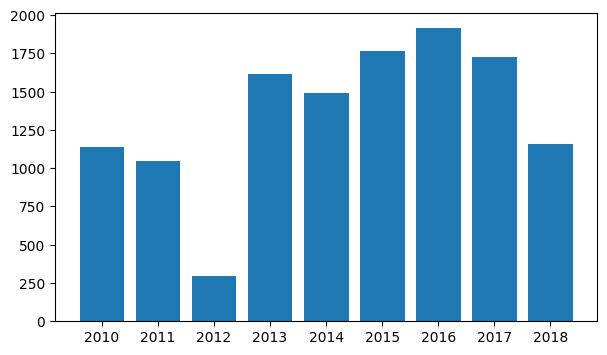

In [30]:
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(bars, lengths)
ax.set_xticks(bars)
plt.show()

Observe that unlike the for the bars, the order of the pie slices is affected by how the data is sorted.

When passing columns separately, be sure that the row order remains consistent.

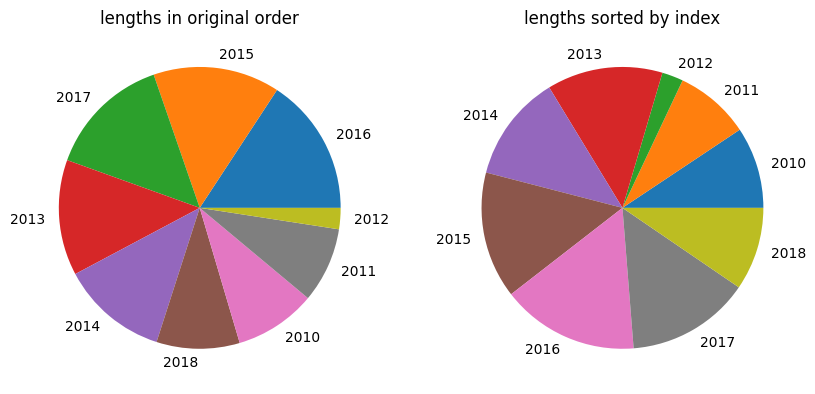

In [31]:
lengths_sorted = season_counts.sort_index()
bars_sorted = lengths_sorted.index

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.pie(lengths, labels=bars)
ax1.set_title("lengths in original order")
ax2.pie(lengths_sorted, labels=bars_sorted)
ax2.set_title("lengths sorted by index")
plt.show()

We can use the `groupby()` function to perform a grouping operation.

The result is a special object, which (in short) can be used to perform aggregations.

In [32]:
df_seasons = df.groupby(['Season'])

In [33]:
bars = df_seasons.groups.keys()
bars

dict_keys([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

An aggregation can be peformed on the result of the `groupby()` function as follows. The result is a `DataFrame` again.

In [34]:
df_scored = df_seasons[['Scored']].sum()
df_scored

,Scored
Season,
2010,1222
2011,1161
2012,345
2013,1767
2014,1689
2015,2084
2016,2374
2017,2045
2018,1406


We can manually construct the plots with Matplotlib.

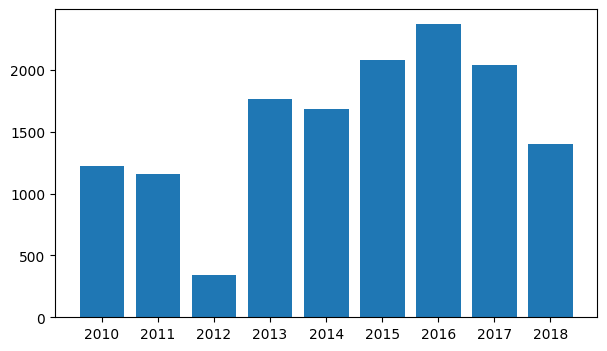

In [35]:
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(bars, df_scored['Scored'])
ax.set_xticks(list(bars))
plt.show()

Alternatively, `pandas` has a built in plotting feature, as demonstrated below.

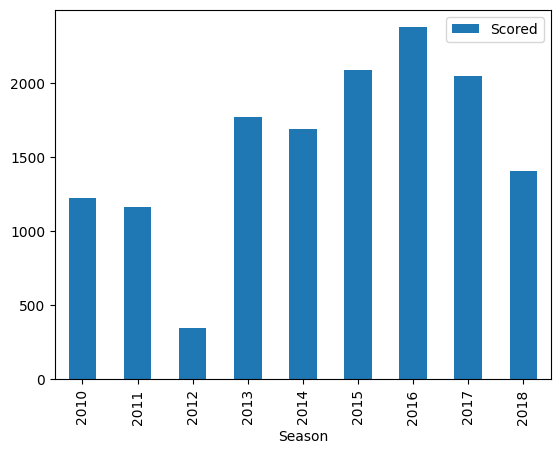

In [36]:
df_scored.plot(kind="bar", y='Scored')
plt.show()

We can choose multiple columns to summarize and to visualize after grouping.

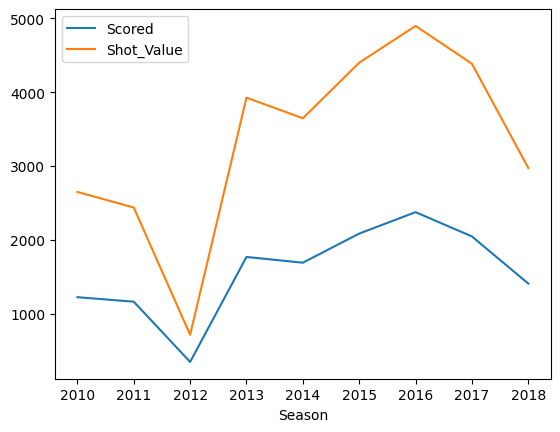

In [37]:
df_seasons[['Scored','Shot_Value']].sum().plot.line(y=['Scored','Shot_Value'])
plt.show()

Consider the following problem. We need to display a chart which shows total successful shots against different opponents (as colors), in each season (as an axis).

We can group by both the `Season` and `Opponent` fields.

Note: use double brackets when choosing the `Outcome` field, as the result should be a `DataFrame`. If a single bracket is used instead, the result is a `Series`.

In [38]:
df_success = df.groupby(['Season','Opponent'])
df_success_sums = df_success[['Outcome']].sum()
df_success_sums

Outcome
Season Opponent         
2010   ATL            24
       BOS             4
       CHA            16
       CHI            12
       CLE            14
...                  ...
2018   SAC             7
       SAS            14
       TOR            15
       UTA             4
       WAS            12

[244 rows x 1 columns]

Plotting this aggregation is, however, is not what we want.

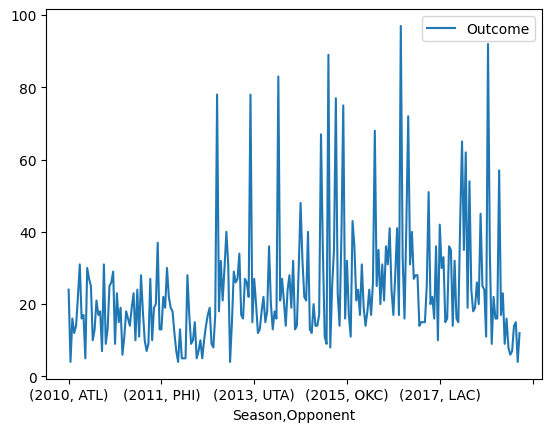

In [39]:
df_success_sums.plot(y='Outcome')
plt.show()

We can perform an operation called **unstacking**.

From the multi-dimensional index, a field can be moved to form column labels.

Note: unstacking is roughly equivalent to the pivoting operation in Power BI, Power Query Editor.

In [40]:
# df_success_sums.unstack() # same result
df_success_sums.unstack(level='Opponent')

Outcome                                                        ...  \
Opponent     ATL   BOS   BRK   CHA   CHI   CHO   CLE   DAL   DEN   DET  ...   
Season                                                                  ...   
2010        24.0   4.0   NaN  16.0  12.0   NaN  14.0  22.0  31.0  16.0  ...   
2011         6.0  11.0   NaN  18.0  16.0   NaN  14.0  19.0  23.0  10.0  ...   
2012         NaN   NaN   NaN   NaN   7.0   NaN   NaN   4.0  13.0   NaN  ...   
2013        10.0  14.0  17.0  19.0   9.0   NaN   8.0  17.0  78.0  18.0  ...   
2014        12.0  13.0  18.0  22.0  15.0   NaN  18.0  36.0  20.0  13.0  ...   
2015        12.0  20.0  14.0   NaN  14.0  17.0  67.0  35.0  11.0   9.0  ...   
2016        14.0  18.0  24.0   NaN  17.0  26.0  68.0  25.0  35.0  20.0  ...   
2017        14.0  15.0  15.0   NaN  15.0  25.0  51.0  20.0  22.0  16.0  ...   
2018        18.0  19.0  26.0   NaN  20.0   NaN  45.0  25.0  24.0  11.0  ...   

                                                                      
Opponent   OKC   ORL   PHI   PHO   POR   SAC   SAS   TOR   UTA   WAS  
Season                                                                
2010      31.0   9.0  13.0  25.0  26.0  29.0   9.0  23.0  15.0  19.0  
2011      37.0  13.0  13.0  22.0  19.0  30.0  22.0  19.0  18.0  12.0  
2012      17.0   NaN   9.0  10.0  15.0   5.0   7.0   NaN  10.0   5.0  
2013      34.0  17.0  16.0  27.0  26.0  22.0  78.0  15.0  27.0  20.0  
2014      32.0  13.0  14.0  30.0  48.0  32.0  22.0  21.0  40.0  13.0  
2015      32.0  17.0  11.0  43.0  36.0  21.0  24.0  17.0  31.0  19.0  
2016      97.0  33.0  16.0  42.0  72.0  31.0  40.0  27.0  28.0  28.0  
2017      32.0  16.0  15.0  43.0  65.0  35.0  62.0  19.0  54.0  24.0  
2018      23.0   9.0  16.0   8.0   6.0   7.0  14.0  15.0   4.0  12.0  

[9 rows x 32 columns]

Any column in the index can be chosen.

In [41]:
df_success_sums.unstack(level='Season').head(7)

Outcome                                               
Season      2010  2011 2012  2013  2014  2015  2016  2017  2018
Opponent                                                       
ATL         24.0   6.0  NaN  10.0  12.0  12.0  14.0  14.0  18.0
BOS          4.0  11.0  NaN  14.0  13.0  20.0  18.0  15.0  19.0
BRK          NaN   NaN  NaN  17.0  18.0  14.0  24.0  15.0  26.0
CHA         16.0  18.0  NaN  19.0  22.0   NaN   NaN   NaN   NaN
CHI         12.0  16.0  7.0   9.0  15.0  14.0  17.0  15.0  20.0
CHO          NaN   NaN  NaN   NaN   NaN  17.0  26.0  25.0   NaN
CLE         14.0  14.0  NaN   8.0  18.0  67.0  68.0  51.0  45.0

As an alternative to `groupby()` + `unstack()`, the function `pivot_table()` can be used that almost does the same.

In [42]:
df_success_sums_withpivot = df.pivot_table(
    values="Outcome",
    index="Season",
    columns="Opponent",
    aggfunc="sum",
    # fill_value=0, # optional, replaces NaN values
)
df_success_sums_withpivot

Opponent,ATL,BOS,BRK,CHA,CHI,CHO,CLE,DAL,DEN,DET,...,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS
Season,,,,,,,,,,,,,,,,,,,,,
2010,24.0,4.0,NaN,16.0,12.0,NaN,14.0,22.0,31.0,16.0,...,31.0,9.0,13.0,25.0,26.0,29.0,9.0,23.0,15.0,19.0
2011,6.0,11.0,NaN,18.0,16.0,NaN,14.0,19.0,23.0,10.0,...,37.0,13.0,13.0,22.0,19.0,30.0,22.0,19.0,18.0,12.0
2012,NaN,NaN,NaN,NaN,7.0,NaN,NaN,4.0,13.0,NaN,...,17.0,NaN,9.0,10.0,15.0,5.0,7.0,NaN,10.0,5.0
2013,10.0,14.0,17.0,19.0,9.0,NaN,8.0,17.0,78.0,18.0,...,34.0,17.0,16.0,27.0,26.0,22.0,78.0,15.0,27.0,20.0
2014,12.0,13.0,18.0,22.0,15.0,NaN,18.0,36.0,20.0,13.0,...,32.0,13.0,14.0,30.0,48.0,32.0,22.0,21.0,40.0,13.0
2015,12.0,20.0,14.0,NaN,14.0,17.0,67.0,35.0,11.0,9.0,...,32.0,17.0,11.0,43.0,36.0,21.0,24.0,17.0,31.0,19.0
2016,14.0,18.0,24.0,NaN,17.0,26.0,68.0,25.0,35.0,20.0,...,97.0,33.0,16.0,42.0,72.0,31.0,40.0,27.0,28.0,28.0
2017,14.0,15.0,15.0,NaN,15.0,25.0,51.0,20.0,22.0,16.0,...,32.0,16.0,15.0,43.0,65.0,35.0,62.0,19.0,54.0,24.0
2018,18.0,19.0,26.0,NaN,20.0,NaN,45.0,25.0,24.0,11.0,...,23.0,9.0,16.0,8.0,6.0,7.0,14.0,15.0,4.0,12.0


A key difference is that `Outcome` is no longer part of the `DataFrame`. Therefore, when plotting, it does not need to be referenced. This is demonstrated in the following examples.

The following code plots the required chart, although the legend is ugly.

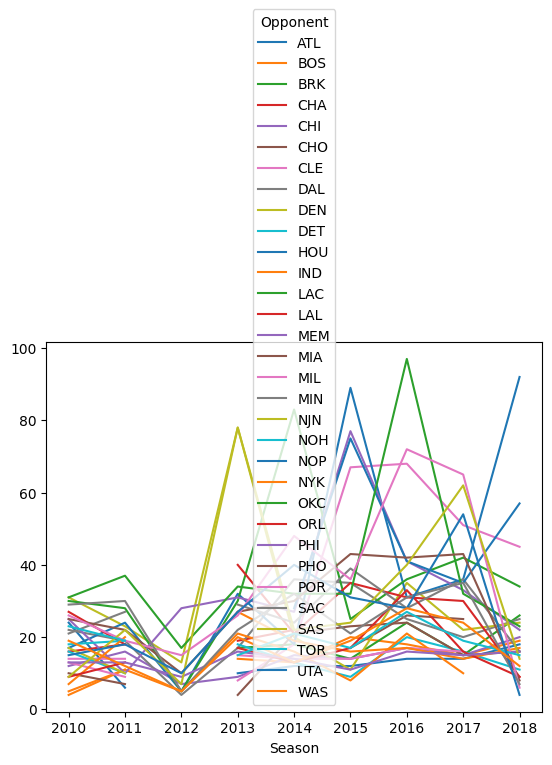

In [43]:
# df_success_sums.unstack(level='Opponent').plot(y='Outcome')
df_success_sums_withpivot.plot()
plt.show()

With the `ax` parameter we can define and format the figure and the axis in the usual way, after populating it from a `DataFrame`.

Colors loop over a set of 10 colors by default, although this could be customized by assigning a custom color map. Note that with this number of opponents, multiple charts could be better.

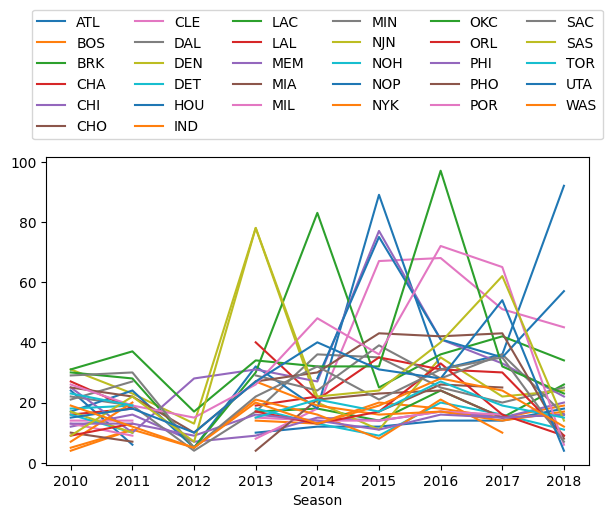

In [44]:
fig, ax = plt.subplots(figsize=(7,4))
df_success_sums.unstack(level='Opponent').plot(y='Outcome', ax=ax)
# df_success_sums_withpivot.plot(ax=ax)
ax.legend(loc="upper center", ncol=6, bbox_to_anchor=(0.5,1.5))
plt.show()

Alternatively, a stacked bar chart is easy to draw using this method.

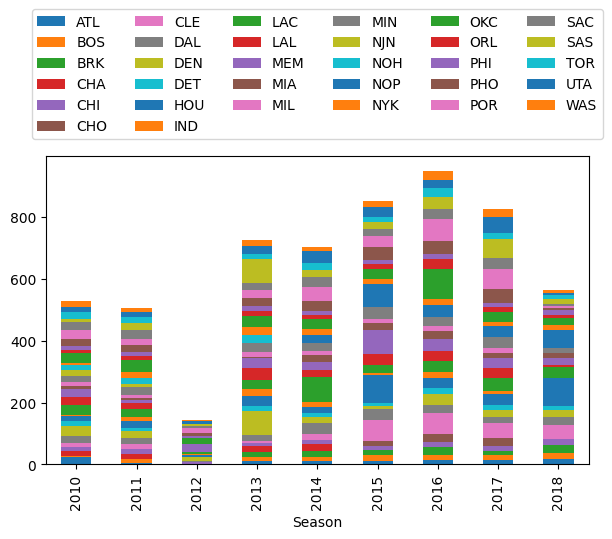

In [45]:
fig, ax = plt.subplots(figsize=(7,4))
df_success_sums.unstack(level='Opponent').plot(
    kind="bar", y='Outcome', stacked=True, ax=ax)
# df_success_sums_withpivot.plot(kind="bar", stacked=True, ax=ax)
ax.legend(loc="upper center", ncol=6, bbox_to_anchor=(0.5,1.5))
plt.show()

Alternatively, we can extract and prepare the data manually, as shown below.

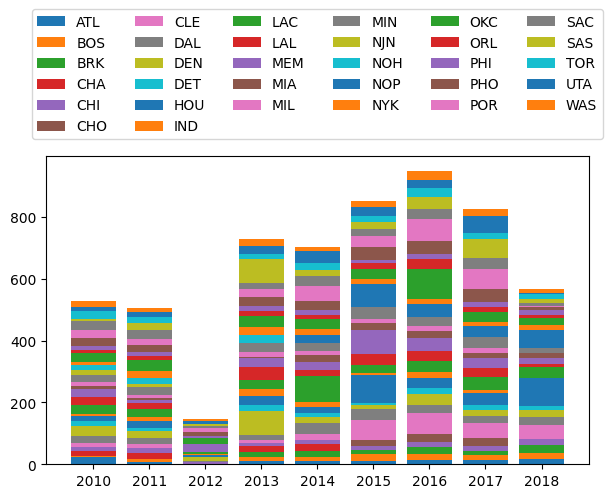

In [46]:
df_success_sums = df_success[['Outcome']].sum()

# years = set()
# opponents = set()
# for year, opponent in df_success_sums.index:
#   years.add(year)
#   opponents.add(opponent)
# years = sorted(list(years))
# opponents = sorted(list(opponents))
years = sorted(df_success_sums.index.get_level_values(0).unique())
opponents = sorted(df_success_sums.index.get_level_values(1).unique())

fig, ax = plt.subplots(figsize=(7,4))

bar_bottoms = np.zeros(len(years))
for opponent in opponents:
  lengths = []
  for year in years:
    lengths.append(df_success_sums.loc[year,'Outcome'].get(opponent, 0))
  ax.bar(years, lengths, width=0.8, label=opponent, bottom=bar_bottoms)
  bar_bottoms += lengths

ax.set_xticks(years)
ax.legend(loc="upper center", ncol=6, bbox_to_anchor=(0.5, 1.5))
plt.show()

### Exercise 2.

Display the positions of all shots in the last season. Show successful and unsuccessful shots in different styles.

### Exercise 3.

Display the same positions on the scatter chart, but denote outcome by different markers instead of colors.

### Exercise 4.

Display a chart which shows total scored points based on distance groups 0-4, 5-12, 13-21, and 22+ feet (as an axis), and by location (home or away, as color).

Tip: check out the documentation of the `cut()` function in `pandas`.

### Exercise 5.

Plot the shot success rate for each season, further categorized by shot value.